# Medical Cost Analysis and Insurance Forecast

## Import Libraries

In [1]:
import os
import pandas as pd
import pandas_profiling
import numpy as np
from numpy import sqrt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Load Dataset

##### Downloading the dataset from Kaggle

In [2]:
!pip install opendatasets

import opendatasets as od

od.download("https://www.kaggle.com/datasets/mirichoi0218/insurance")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 16.0k/16.0k [00:00<00:00, 12.5MB/s]

##### Reading csv file into a dataframe called dataset

In [3]:
os.rename("./insurance", "./data")
csv_file =('data/insurance.csv')
dataset = pd.read_csv(csv_file)
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis

In [4]:
#Getting an overview of the dataset

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
#Getting the number of missing values in the dataset

dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
#Getting the number of each value in each column seperately

for column_name in dataset.columns:
    print ("---- %s ---" % column_name)
    print (dataset[column_name].value_counts())

---- age ---
18    69
19    68
50    29
51    29
47    29
46    29
45    29
20    29
48    29
52    29
22    28
49    28
54    28
53    28
21    28
26    28
24    28
25    28
28    28
27    28
23    28
43    27
29    27
30    27
41    27
42    27
44    27
31    27
40    27
32    26
33    26
56    26
34    26
55    26
57    26
37    25
59    25
58    25
36    25
38    25
35    25
39    25
61    23
60    23
63    23
62    23
64    22
Name: age, dtype: int64
---- sex ---
male      676
female    662
Name: sex, dtype: int64
---- bmi ---
32.300    13
28.310     9
30.495     8
30.875     8
31.350     8
          ..
46.200     1
23.800     1
44.770     1
32.120     1
30.970     1
Name: bmi, Length: 548, dtype: int64
---- children ---
0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64
---- smoker ---
no     1064
yes     274
Name: smoker, dtype: int64
---- region ---
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64
---

In [7]:
#Getting transposed index and columns of the description of the dataset

dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [8]:
#Finding the pairwise correlation of all columns

correlations = dataset.corr()
correlations

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [9]:
#Finding the pairwise correlation of charges column

charges_correlations = correlations["charges"]
charges_correlations

age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

## Data Visualization

In [10]:
plt.rcParams['figure.figsize'] = 10,6

#####"bmi" distribution

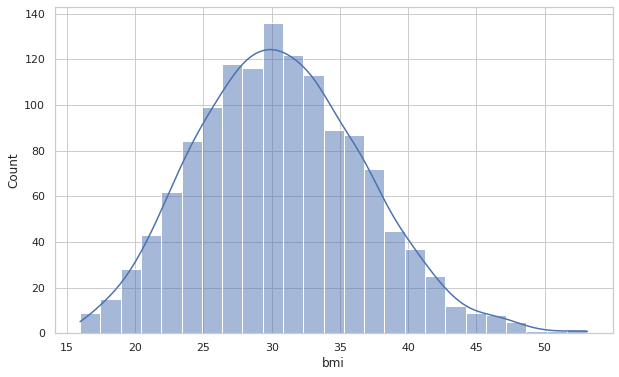

In [11]:
sns.set(style='whitegrid')
sns.histplot(data=dataset, x="bmi", kde=True)

#####Relationship between "smoker" and "charges"

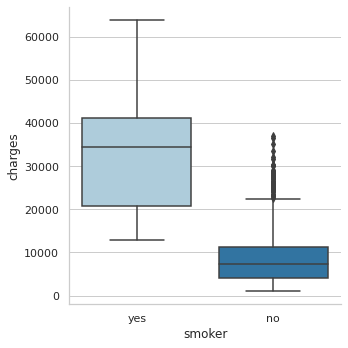

In [12]:
sns.catplot(x="smoker", y="charges", data=dataset, kind="box", palette="Paired")

#####Relationship between "smoker" and "region"



In [13]:
dataset.groupby(["smoker","region"]).size().reset_index(name="count")

,smoker,region,count
0,no,northeast,257
1,no,northwest,267
2,no,southeast,273
3,no,southwest,267
4,yes,northeast,67
5,yes,northwest,58
6,yes,southeast,91
7,yes,southwest,58


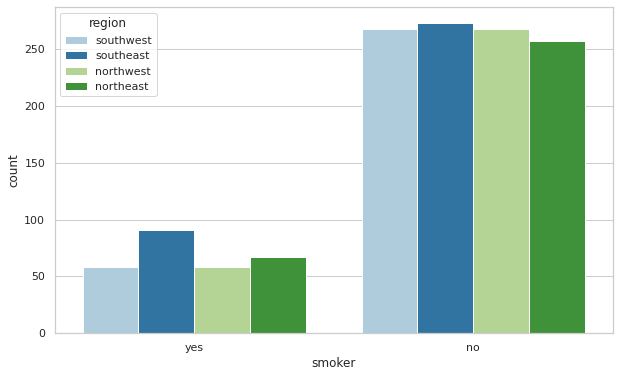

In [14]:
sns.countplot(x="smoker", hue="region", data=dataset, palette="Paired")

#####Relationship between "bmi" and "sex"

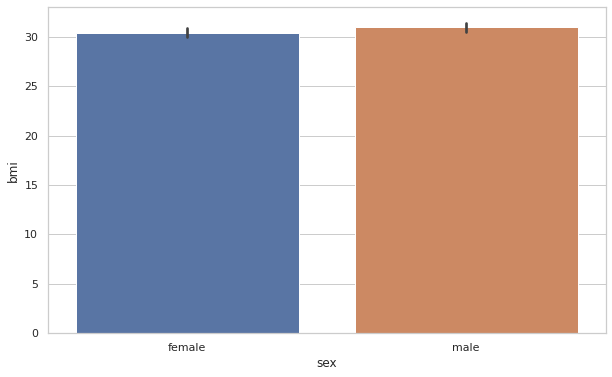

In [15]:
sns.barplot(x=dataset["sex"], y=dataset["bmi"])

In [16]:
dataset[["bmi","sex"]].groupby(["sex"], as_index= False).mean().sort_values(by="bmi", ascending=False)

,sex,bmi
1,male,30.943129
0,female,30.377749


Text(0.5, 1.0, 'Distribution of bmi over males')

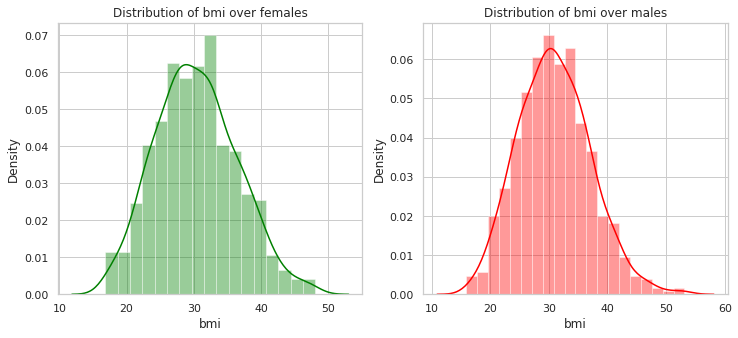

In [17]:
fig = plt.figure(figsize=(12,5))

ax=fig.add_subplot(121)
sns.distplot(dataset[(dataset.sex == 'female')]["bmi"],color='green',ax=ax)
ax.set_title('Distribution of bmi over females')

ax=fig.add_subplot(122)
sns.distplot(dataset[(dataset.sex == 'male')]['bmi'],color='red',ax=ax)
ax.set_title('Distribution of bmi over males')

#####Finding the region in which the maximum number of children lives

In [18]:
#Getting the number of children living in 4 different regions

region_groupby = dataset.groupby(by=["region"])['children'].agg(['count'])
region_groupby

,count
region,
northeast,324
northwest,325
southeast,364
southwest,325


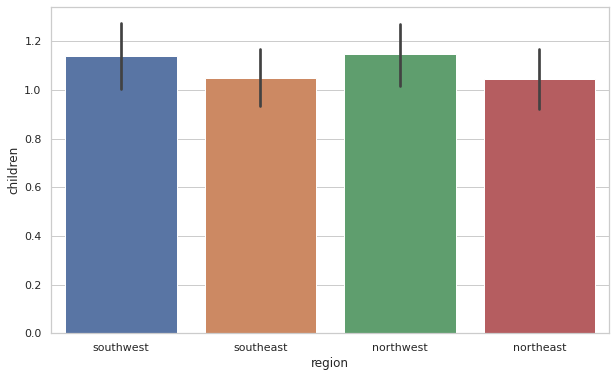

In [19]:
sns.barplot(x = "region", y = "children", data=dataset)

In [20]:
res = region_groupby.apply(lambda x: x.sort_values(ascending=False).head(1))
res

,count
region,
southeast,364


#####Relationship between "age" and "bmi"

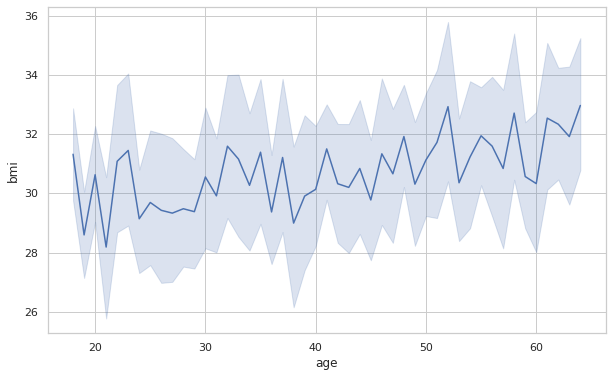

In [21]:
sns.lineplot(x="age", y="bmi", data=dataset, palette="Paired")

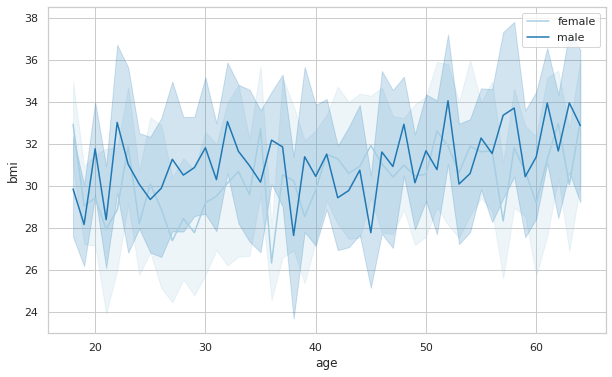

In [22]:
sns.lineplot(x="age", y="bmi", hue="sex", data=dataset, palette="Paired").legend(loc="best")

#####Relationship between "bmi" and "children"

In [23]:
dataset.groupby(["children"])["bmi"].describe()

,count,mean,std,min,25%,50%,75%,max
children,,,,,,,,
0,574.0,30.550296,6.039106,15.960,26.14375,30.3025,34.74625,53.13
1,324.0,30.623148,6.101435,16.815,26.61500,30.0150,34.23750,52.58
2,240.0,30.978104,6.509644,16.815,25.78625,31.6400,35.35750,48.07
3,157.0,30.684331,5.787173,18.905,27.26500,30.4950,34.32000,46.53
4,25.0,31.391200,4.627211,24.415,28.21500,29.6400,33.66000,41.47
5,18.0,29.605000,7.139686,18.300,24.30250,28.5500,33.05500,46.75


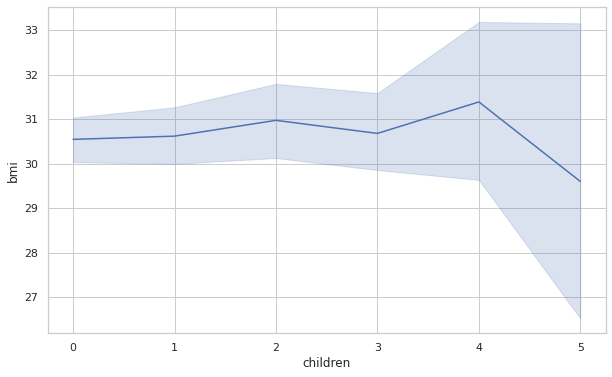

In [24]:
sns.lineplot(x = "children", y = "bmi", data=dataset, palette="Paired")

#####Checking the existence of "bmi"'s outlier

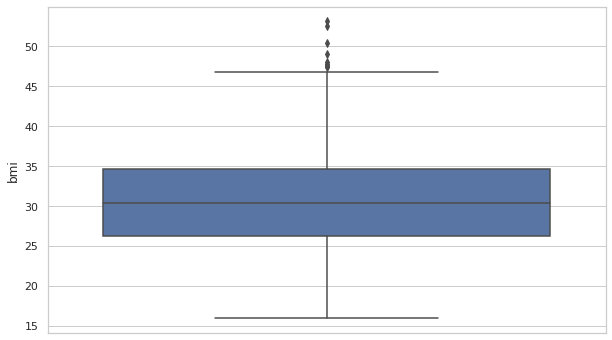

In [25]:
sns.boxplot(y = "bmi", data=dataset)

#####Relationship between "bmi" and "charges"

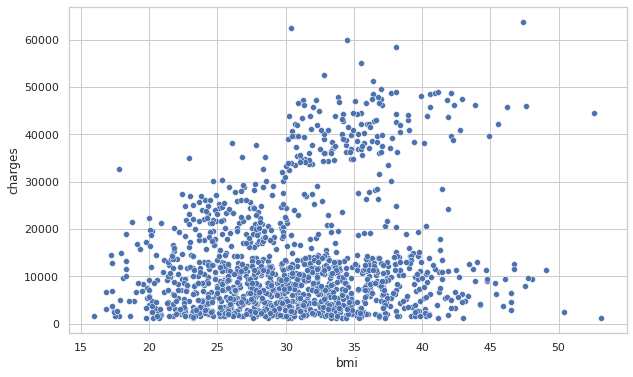

In [26]:
sns.scatterplot(x = "bmi", y="charges", data=dataset, palette="Paired")

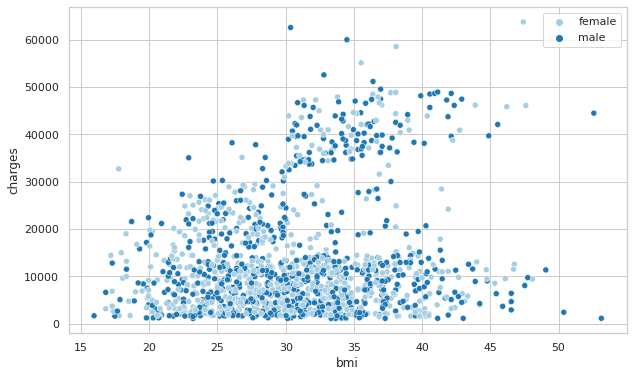

In [27]:
sns.scatterplot(x = "bmi", y="charges", hue="sex", data=dataset, palette="Paired").legend(loc="best")

#####Relationship between "region", "smoker", and "bmi"

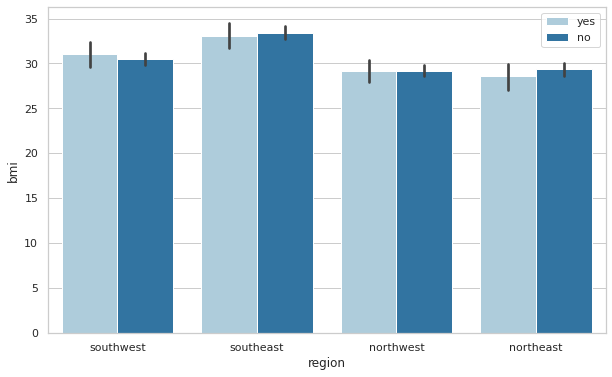

In [28]:
sns.barplot(x = "region", y = "bmi", hue = "smoker", data=dataset, palette="Paired").legend(loc="best")

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

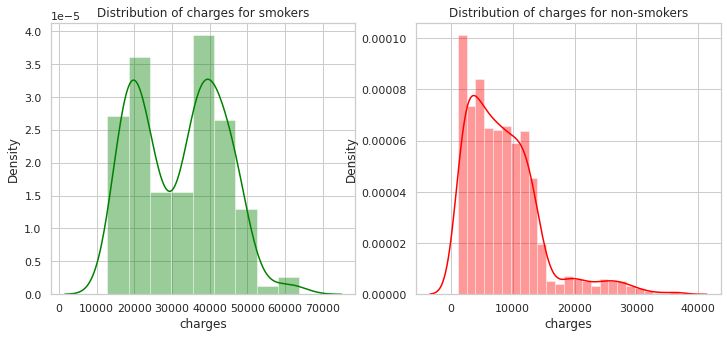

In [29]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(dataset[(dataset.smoker == 'yes')]["charges"],color='green',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(dataset[(dataset.smoker == 'no')]['charges'],color='red',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

## Data Preprocessing

##### Converting sex, smoker and region's type from object to categorical

In [30]:
dataset[['sex', 'smoker', 'region']] = dataset[['sex', 'smoker', 'region']].astype('category')
dataset.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

##### Encoding region category using one hot encoder

In [31]:
dataset = pd.get_dummies(dataset, columns = ['region'])
dataset

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,16884.92400,0,0,0,1
1,18,male,33.770,1,no,1725.55230,0,0,1,0
2,28,male,33.000,3,no,4449.46200,0,0,1,0
3,33,male,22.705,0,no,21984.47061,0,1,0,0
4,32,male,28.880,0,no,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,10600.54830,0,1,0,0
1334,18,female,31.920,0,no,2205.98080,1,0,0,0
1335,18,female,36.850,0,no,1629.83350,0,0,1,0
1336,21,female,25.800,0,no,2007.94500,0,0,0,1


##### Encoding sex and smoker categories using label encoder

In [32]:
le = LabelEncoder()
dataset['sex'] = le.fit_transform(dataset['sex'].values)
dataset['smoker'] = le.fit_transform(dataset['smoker'].values)
dataset

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,1,0,0
1334,18,0,31.920,0,0,2205.98080,1,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,0,1


## Data Normalization

###### Normalizing the dataset and scaling it between 0 and 1

In [33]:
norm_dataset = dataset.copy()
norm_dataset[['age', 'bmi', 'children', 'charges']] = minmax_scale(norm_dataset[['age', 'bmi', 'children', 'charges']])
norm_dataset.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0,0.321227,0.0,1,0.251611,0,0,0,1
1,0.000000,1,0.479150,0.2,0,0.009636,0,0,1,0
2,0.217391,1,0.458434,0.6,0,0.053115,0,0,1,0
3,0.326087,1,0.181464,0.0,0,0.333010,0,1,0,0
4,0.304348,1,0.347592,0.0,0,0.043816,0,1,0,0


## Data Splitting

##### Splitting the dataset into training(85%) and test data(15%)

In [34]:
x = norm_dataset.drop(columns=["charges"]).to_numpy()
y = norm_dataset[["charges"]].to_numpy()

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

## Modelling


##### Defining different types of regression models

In [36]:
models = { LinearRegression(): "Linear Regressor",
           Ridge(alpha=0.05, normalize=True): "Ridge Regressor",
           HistGradientBoostingRegressor(): "Hist Gradient Boosting Regressor",
           RandomForestRegressor(max_depth=2, random_state=0): "Random Forest Regressor",
           BayesianRidge(): "Bayesian Ridge Regressor",
           AdaBoostRegressor(random_state=0, n_estimators=100): "Ada Boost Regressor",
           SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1): "Support Vector RBF Regressor",
           SVR(kernel="linear", C=100, gamma="auto"): "Support Vector Linear Regressor"}

model_names = models.values()

In [37]:
def models_fit(models, x_train, y_train):
    for model in models.keys():
        model.fit(x_train, y_train)

In [38]:
models_fit(models, x_train, y_train)

## Model Prediction

In [39]:
def models_predict(models, x_test):
    predictions = {}
    for model, model_name in models.items():
        predictions[model_name]= model.predict(x_test)

    return predictions

In [40]:
all_predictions = models_predict(models, x_test)

## Model Evaluation

##### Cross Validation

In [41]:
def cv_eval(models, x_test, y_test):
    cv_results = {}
    for model, model_name in models.items():
        cv_results[model] = cross_val_score(model, x_test, y_test, cv=3).mean()

    return cv_results

In [42]:
cv_results = cv_eval(models, x, y)
cv_best_model = [model for model in models if cv_results[model]==max(cv_results.values())][0]

<function matplotlib.pyplot.show(*args, **kw)>

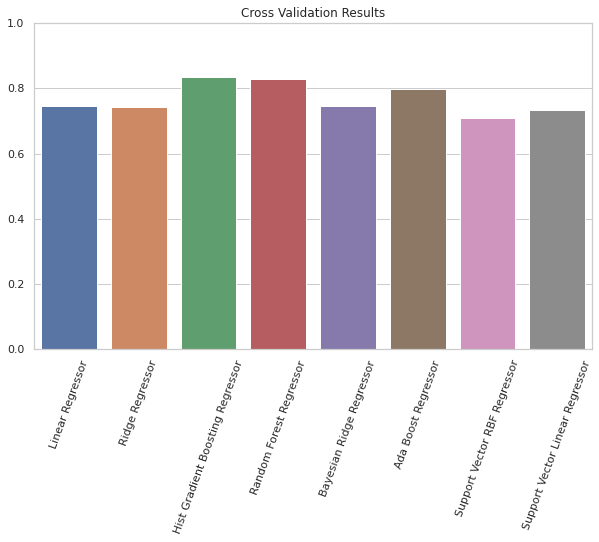

In [43]:
fig, ax = plt.subplots(figsize = (10,6))
fig = sns.barplot(x=list(models.values()), y= list(cv_results.values()), ax=ax)
plt.title("Cross Validation Results")
plt.xticks(rotation=70)
plt.ylim((0,1))
plt.show

##### MSE, MAE and R2 Evaluation


In [44]:
def models_eval(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  return mse, mae, r2

In [45]:
errors_list = []
for model_name, predictions in all_predictions.items():
  mse, mae, r2 = models_eval(y_test, predictions)
  errors = {"Models": model_name, "ErrorMean": ((1-r2)+mse+mae)/3, "R2Score": r2, "1-R2Score": 1-r2, "MSError": mse, "MAError": mae,}
  errors_list.append(errors)

In [46]:
df_errors = pd.DataFrame(errors_list)

In [47]:
copy_df = df_errors.copy().style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
copy_df.set_properties(**{'text-align': 'left'}).hide_index()

Models,ErrorMean,R2Score,1-R2Score,MSError,MAError
Linear Regressor,0.091862,0.796939,0.203061,0.007878,0.064649
Ridge Regressor,0.093184,0.794354,0.205646,0.007978,0.065929
Hist Gradient Boosting Regressor,0.061791,0.862114,0.137886,0.005349,0.042138
Random Forest Regressor,0.067712,0.851856,0.148144,0.005747,0.049245
Bayesian Ridge Regressor,0.091646,0.797333,0.202667,0.007863,0.064408
Ada Boost Regressor,0.084675,0.817457,0.182543,0.007082,0.064401
Support Vector RBF Regressor,0.124534,0.730769,0.269231,0.010445,0.093928
Support Vector Linear Regressor,0.099144,0.784146,0.215854,0.008374,0.073203


##### Sorting the dataframe called df_error by the values of its ErrorMean column

In [48]:
df_errors = df_errors.sort_values(by=['ErrorMean'], ignore_index=True)

In [49]:
copy_df = df_errors.copy().style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
copy_df.set_properties(**{'text-align': 'left'}).hide_index()

Models,ErrorMean,R2Score,1-R2Score,MSError,MAError
Hist Gradient Boosting Regressor,0.061791,0.862114,0.137886,0.005349,0.042138
Random Forest Regressor,0.067712,0.851856,0.148144,0.005747,0.049245
Ada Boost Regressor,0.084675,0.817457,0.182543,0.007082,0.064401
Bayesian Ridge Regressor,0.091646,0.797333,0.202667,0.007863,0.064408
Linear Regressor,0.091862,0.796939,0.203061,0.007878,0.064649
Ridge Regressor,0.093184,0.794354,0.205646,0.007978,0.065929
Support Vector Linear Regressor,0.099144,0.784146,0.215854,0.008374,0.073203
Support Vector RBF Regressor,0.124534,0.730769,0.269231,0.010445,0.093928


##### Choosing the best model

In [50]:
best_model = [model for model in models if models[model]==df_errors['Models'][0]][0]

In [51]:
print(f"{models[best_model]} is chosen as the best model.")

Hist Gradient Boosting Regressor is chosen as the best model.


##### Visualizing the R2 score of each model

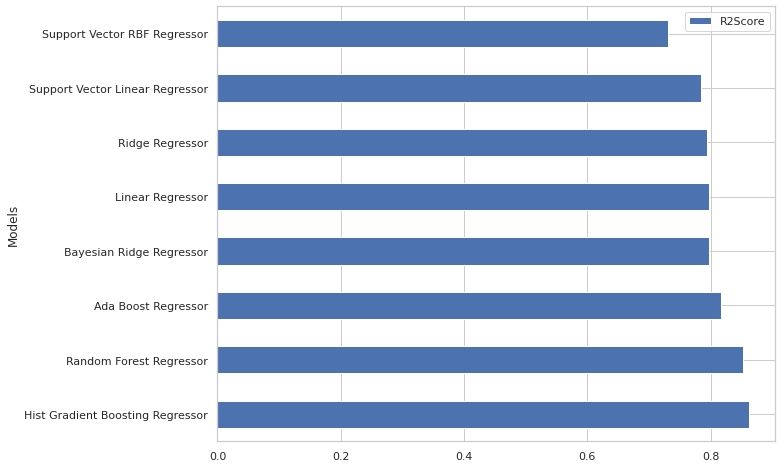

In [52]:
df_errors.plot(x='Models', y='R2Score', kind="barh", figsize=(10, 8))

##### Visualizing the errors along with their mean of each model

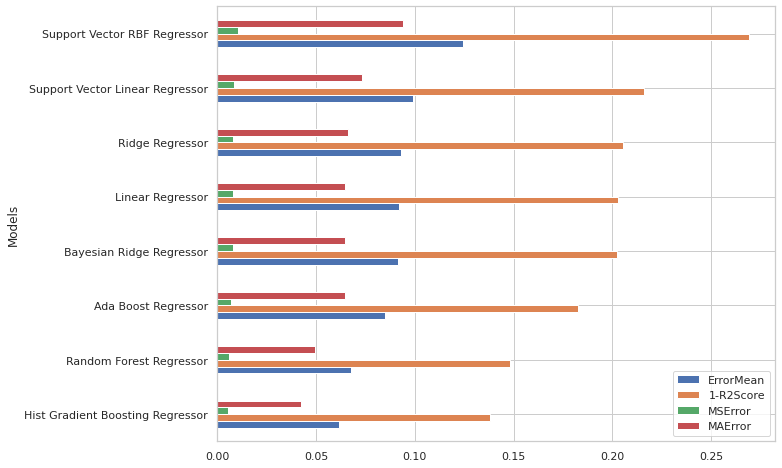

In [53]:
df_errors.plot(x='Models', y=['ErrorMean', '1-R2Score', 'MSError', 'MAError'], kind="barh", figsize=(10, 8))

##### Comparing Evaluation Results

In [54]:
if cv_best_model == best_model:
  print(f"The best model according to evaluation using cross validation and chosen metrics is {models[cv_best_model]}.")
else:
  print(f"Best model according to evaluation using cross validation is {models[cv_best_model]}.\n"
        f"Best model according to evaluation using chosen metrics is {models[best_model]}.")

The best model according to evaluation using cross validation and chosen metrics is Hist Gradient Boosting Regressor.


## Hyperparameter Optimization

In [55]:
#Checking model specific parameters

for model, model_name in models.items():
  print(f"{model_name}'s parameters': {model.get_params()}")

Linear Regressor's parameters': {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
Ridge Regressor's parameters': {'alpha': 0.05, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
Hist Gradient Boosting Regressor's parameters': {'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Random Forest Regressor's parameters': {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_s

In [56]:
#Varying some chosen parameters for different type of models

def vary_param(model):
  params = {}

  if 'fit_intercept' in model.get_params():
    params['fit_intercept'] = [True, False]
  if 'normalize' in model.get_params():
    params['normalize'] = [True, False]
  if 'copy_X' in model.get_params():
    params['copy_X'] = [True, False]
  if 'bootstrap' in model.get_params():
    params['bootstrap'] = [True, False]
  if 'max_features' in model.get_params():
    params['max_features'] = ['auto', 'log2', 'sqrt']
  if 'kernel' in model.get_params():
    params['kernel'] = ['rbf', 'poly', 'sigmoid']
  if 'solver' in model.get_params():
    params['solver'] = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
  if 'learning_rate' in model.get_params():
    params['learning_rate'] = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
  if 'alpha' in model.get_params():
    params['alpha'] = [1, 0.1, 0.01, 0.001, 0.0001]
  if 'alpha_1' in model.get_params():
    params['alpha_1'] = [1, 0.1, 0.01, 0.001, 0.0001]
  if 'alpha_2' in model.get_params():
    params['alpha_2'] = [1, 0.1, 0.01, 0.001, 0.0001]
  if 'max_depth' in model.get_params():
    params['max_depth'] = [1, 2, 3, 4, 5, None]
  if 'min_samples_leaf' in model.get_params():
    params['min_samples_leaf'] = [1, 2, 4]
  if 'min_samples_split' in model.get_params():
    params['min_samples_split'] = [2, 5, 10]
  if 'n_estimators' in model.get_params():
    params['n_estimators'] = [10,50,250,1000]
  if 'C' in model.get_params():
    params['C'] = [0.1,1, 10, 100]
  if 'gamma' in model.get_params():
    params['gamma'] = [1,0.1,0.01,0.001,0.0001]
  if 'epsilon' in model.get_params():
    params['epsilon'] = [0.01, 0.1, 1]

  return params

In [57]:
#Optimizing the hyperparameters using Grid Search and printing the results

def hp_opt(model, x_train, y_train, x_test, y_test):
  grid_search = GridSearchCV(model, param_grid=vary_param(model), n_jobs=-1, cv=3)
  grid_search.fit(x_train, y_train)
  accuracy = grid_search.score(x_test, y_test)*100
  print( f"--------------------------------------------------\n"
         f"Model name: {models[model]}\n"
         f"Test accuracy score: {accuracy:.2f}%\n"
         f"Best parameters: {grid_search.best_params_}")
  
  return model

##### Hyperparameter Optimization for the Best Model

In [58]:
#Getting the results of the best model using hyperparameter optimization

best_model = hp_opt(best_model, x_train, y_train, x_test, y_test)

--------------------------------------------------
Model name: Hist Gradient Boosting Regressor
Test accuracy score: 88.50%
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4}


In [59]:
#Checking the functionality of vary_param function by calling it for other models

for each_model in models.keys():
  if best_model != each_model:
    hp_opt(each_model, x_train, y_train, x_test, y_test)

--------------------------------------------------
Model name: Linear Regressor
Test accuracy score: 79.69%
Best parameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False}
--------------------------------------------------
Model name: Ridge Regressor
Test accuracy score: 79.75%
Best parameters: {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}
--------------------------------------------------
Model name: Random Forest Regressor
Test accuracy score: 87.26%
Best parameters: {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}
--------------------------------------------------
Model name: Bayesian Ridge Regressor
Test accuracy score: 79.72%
Best parameters: {'alpha_1': 0.0001, 'alpha_2': 1, 'copy_X': True, 'fit_intercept': False, 'normalize': True}
--------------------------------------------------
Model name: Ada Boost Regressor
Test accuracy score: 85.55%
B

## Saving the Best Model

In [60]:
os.mkdir("./model")
pickle.dump(best_model, open("./model/"+ models[best_model] + ".pkl", "wb"))